# Dataset

In [1]:
tag2id = {'action': 1, 'actor': 2, 'artifact': 3, 'condition': 4, 'location': 5, 'modality': 6, 'reference': 7, 'time': 8}
id2tag = {v:k for k, v in tag2id.items()}

In [2]:
label2id = {
    'O': 0,
    **{f'{k}': v for k, v in tag2id.items()}
}

id2label = {v:k for k, v in label2id.items()}

In [3]:
from datasets import Dataset
train_ds = Dataset.from_json("../../data/annotations.train.jsonlines")
val_ds = Dataset.from_json("../../data/annotations.eval.jsonlines")

In [4]:
modelId = '../../models/LegalCamemBERT-base'

# Tokenization

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(modelId)

In [6]:
def get_token_role_in_span(token_start: int, token_end: int, span_start: int, span_end: int):
    """
    Check if the token is inside a span.
    Args:
      - token_start, token_end: Start and end offset of the token
      - span_start, span_end: Start and end of the span
    Returns:
      - "B" if beginning
      - "I" if inner
      - "O" if outer
      - "N" if not valid token (like <SEP>, <CLS>, <UNK>)
    """
    if token_end <= token_start:
        return "N"
    if token_start < span_start or token_end > span_end:
        return "O"
    else:
        return "I"

MAX_LENGTH = 256

def tokenize_and_adjust_labels(sample):
    """
    Args:
        - sample (dict): {"id": "...", "text": "...", "tags": [{"start": ..., "end": ..., "tag": ...}, ...]
    Returns:
        - The tokenized version of `sample` and the labels of each token.
    """
    # Tokenize the text, keep the start and end positions of tokens with `return_offsets_mapping` option
    # Use max_length and truncation to ajust the text length
    tokenized = tokenizer(sample["text"],
                          return_offsets_mapping=True,
                          padding="max_length",
                          max_length=MAX_LENGTH,
                          truncation=True)

    # We are doing a multilabel classification task at each token, we create a list of size len(label2id)=13 
    # for the 13 labels
    labels = [[0 for _ in label2id.keys()] for _ in range(MAX_LENGTH)]

    # Scan all the tokens and spans, assign 1 to the corresponding label if the token lies at the beginning
    # or inside the spans
    for (token_start, token_end), token_labels in zip(tokenized["offset_mapping"], labels):
        #print(token_start, token_end)
        for span in sample["tags"]:
            role = get_token_role_in_span(token_start, token_end, span["start"], span["end"])
            if role == "I":
                token_labels[label2id[f"{span['tag']}"]] = 1

    return {**tokenized, "labels": labels}

In [7]:
tokenized_train_ds = train_ds.map(tokenize_and_adjust_labels, remove_columns=train_ds.column_names)
tokenized_val_ds = val_ds.map(tokenize_and_adjust_labels, remove_columns=val_ds.column_names)

In [8]:
sample = tokenized_train_ds[0]
print("--------Token---------|--------Offset----------|--------Labels----------")
for token_id, token_labels, offset in zip(sample["input_ids"], sample["labels"], sample["offset_mapping"]):
    # Decode the token_id into text
    token_text = tokenizer.decode(token_id)
    
    # Retrieve all the indices corresponding to the "1" at each token, decode them to label name
    labels = [id2label[label_index] for label_index, value in enumerate(token_labels) if value==1]
    
    # Decode those indices into label name
    print(f" {token_text:20} | {offset} | {labels}")
    
    # Finish when we meet the end of sentence.
    if token_text == "</s>": 
        break

--------Token---------|--------Offset----------|--------Labels----------
 <s>                  | [0, 0] | []
 Est                  | [0, 3] | ['action']
 puni                 | [4, 8] | ['action']
 des                  | [9, 12] | ['action']
 mêmes                | [13, 18] | ['action']
 peines               | [19, 25] | ['action']
 le                   | [26, 28] | []
 fait                 | [29, 33] | []
 de                   | [34, 36] | []
 tolérer              | [37, 44] | []
 comme                | [45, 50] | []
 propriétaire         | [51, 63] | ['actor']
 ou                   | [64, 66] | ['actor']
 détenteur            | [67, 76] | ['actor']
 la                   | [77, 79] | []
 mise                 | [80, 84] | []
 en                   | [85, 87] | []
 circulation          | [88, 99] | []
 d                    | [100, 101] | []
                      | [102, 103] | []
 '                    | [102, 103] | []
 un                   | [104, 106] | []
 véhicule             | [107,

In [9]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

# Adapt the model

In [10]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

n_labels = len(id2label)

def divide(a: int, b: int):
    return a / b if b > 0 else 0

def compute_metrics(p):
    """
    Customize the `compute_metrics` of `transformers`
    Args:
        - p (tuple):      2 numpy arrays: predictions and true_labels
    Returns:
        - metrics (dict): f1 score on 
    """
    predictions, true_labels = p

    predicted_labels = np.where(predictions > 0, np.ones(predictions.shape), np.zeros(predictions.shape))
    metrics = {}

    cm = multilabel_confusion_matrix(true_labels.reshape(-1, n_labels), predicted_labels.reshape(-1, n_labels))

    for label_idx, matrix in enumerate(cm):
        if label_idx == 0:
            continue # We don't care about the label "O"
        tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
        precision = divide(tp, tp + fp)
        recall = divide(tp, tp + fn)
        f1 = divide(2 * precision * recall, precision + recall)
        metrics[f"recall_{id2label[label_idx]}"] = recall
        metrics[f"precision_{id2label[label_idx]}"] = precision
        metrics[f"f1_{id2label[label_idx]}"] = f1

    f1_values = {k: v for k, v in metrics.items() if k.startswith('f1_')}
    macro_f1 = sum(f1_values.values()) / len(f1_values)
    metrics["macro_f1"] = macro_f1

    return metrics

In [11]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, TrainerCallback
from transformers import RobertaPreTrainedModel, RobertaModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.models.roberta.modeling_roberta import (
    ROBERTA_INPUTS_DOCSTRING,
    ROBERTA_START_DOCSTRING,
    RobertaEmbeddings,
)
from typing import Optional, Union, Tuple
from transformers.modeling_outputs import TokenClassifierOutput
import torch
from torch import nn
import matplotlib.pyplot as plt
from transformers.trainer_utils import IntervalStrategy
import pandas as pd

class RobertaForSpanCategorization(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    def forward(
            self,
            input_ids: Optional[torch.LongTensor] = None,
            attention_mask: Optional[torch.FloatTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            position_ids: Optional[torch.LongTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            labels: Optional[torch.LongTensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

class TrainingMetricsCallback(TrainerCallback):
    def __init__(self):
        self.macro_f1 = []
        self.steps = []
        self.counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            if 'eval_macro_f1' in metrics:
                self.macro_f1.append(metrics['eval_macro_f1'])
                self.counter += 1
                self.steps.append(self.counter)

# Fine-tuning

In [12]:
training_args = TrainingArguments(
    output_dir="./models/fine_tune_bert_output_span_cat",
    evaluation_strategy="epoch",
    learning_rate=2.5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_steps = 100,
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    log_level='critical',
    seed=12345
)

In [13]:
# Initialize the callback
metrics_callback = TrainingMetricsCallback()

def model_init():
    # For reproducibility
    return RobertaForSpanCategorization.from_pretrained(modelId, id2label=id2label, label2id=label2id)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)
trainer.train()

TrainOutput(global_step=1300, training_loss=0.03139937967061997, metrics={'train_runtime': 569.8788, 'train_samples_per_second': 36.148, 'train_steps_per_second': 2.281, 'total_flos': 2691526921113600.0, 'train_loss': 0.03139937967061997, 'epoch': 100.0})

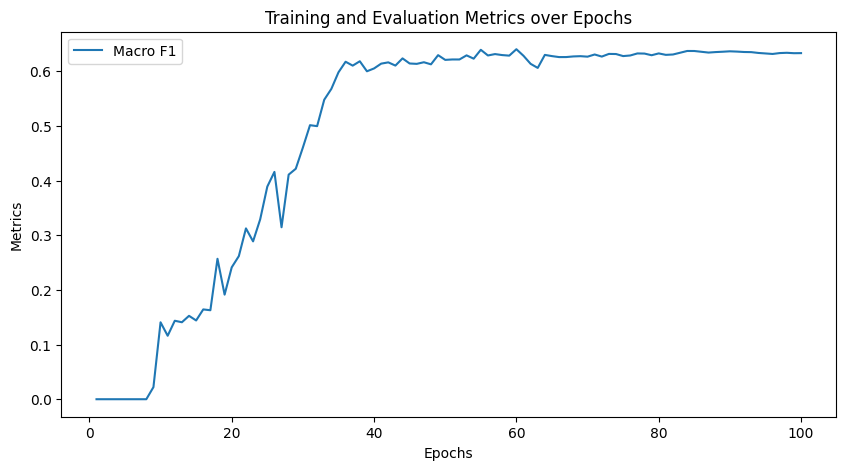

In [14]:
# Plot the training and evaluation metrics
df = pd.DataFrame({'step': metrics_callback.steps})
df['macro_f1'] = pd.Series(metrics_callback.macro_f1)

plt.figure(figsize=(10, 5))
plt.plot(df['step'], df['macro_f1'], label='Macro F1')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training and Evaluation Metrics over Epochs')

plt.savefig('../../results/BERT/legal_bert.png')
plt.show()

In [15]:
trainer.model.save_pretrained("../../models/Fine-tuned_LegalCamemBERT-base")

# Inference

In [16]:
model = RobertaForSpanCategorization.from_pretrained("../../models/Fine-tuned_LegalCamemBERT-base")
tokenizer = AutoTokenizer.from_pretrained(modelId)

In [17]:
def get_offsets_and_predicted_tags(example: str, model, tokenizer, threshold=0):
    """
    Get prediction of model on example, using tokenizer
    Args:
      - example (str): The input text
      - model: The span categorizer
      - tokenizer: The tokenizer
      - threshold: The threshold to decide whether the token should belong to the label. Default to 0, which corresponds to probability 0.5.
    Returns:
      - List of (token, tags, offset) for each token.
    """
    # Tokenize the sentence to retrieve the tokens and offset mappings
    raw_encoded_example = tokenizer(example, return_offsets_mapping=True)
    encoded_example = tokenizer(example, return_tensors="pt")
    
    # Call the model. The output LxK-tensor where L is the number of tokens, K is the number of classes
    out = model(**encoded_example)["logits"][0]
    
    # We assign to each token the classes whose logit is positive
    predicted_tags = [[i for i, l in enumerate(logit) if l > threshold] for logit in out]
    
    return [{"token": token, "tags": tag, "offset": offset} for (token, tag, offset) 
            in zip(tokenizer.batch_decode(raw_encoded_example["input_ids"]), 
                   predicted_tags, 
                   raw_encoded_example["offset_mapping"])]

In [18]:
example = "afin de vérifier le kilométrage , pour les véhicules équipés d ' un compteur kilométrique , les informations communiquées lors du précédent contrôle technique sont mises à la disposition des organismes de contrôle technique dès qu ' elles sont disponibles par voie électronique ."
for item in get_offsets_and_predicted_tags(example, model, tokenizer):
    print(f"""{item["token"]:15} - {item["tags"]}""")

<s>             - []
afin            - []
de              - []
vérifier        - []
le              - []
kilométrage     - []
                - []
,               - []
pour            - []
les             - [3]
véhicules       - [3]
équipés         - [4]
d               - [4]
                - [4]
'               - [4]
un              - [4]
compteur        - [4]
kilo            - [4]
métrique        - [4]
                - []
,               - []
les             - [3]
informations    - [3]
communiquées    - [4]
lors            - [4, 8]
du              - [8]
précédent       - [8]
contrôle        - [8]
technique       - [8]
sont            - [1]
mises           - [1]
à               - [1]
la              - [1]
disposition     - [1]
des             - [1]
organismes      - [1, 2]
de              - [1, 2]
contrôle        - [1, 2]
technique       - [1, 2]
dès             - [4]
qu              - [4]
                - [4]
'               - [4]
elles           - [4]
sont            - [4]
dispon

In [19]:
def get_tagged_groups(example: str, model, tokenizer):
    """
    Get prediction of model on example, using tokenizer
    Returns:
    - List of spans under offset format {"start": ..., "end": ..., "tag": ...}, sorted by start, end then tag.
    """
    offsets_and_tags = get_offsets_and_predicted_tags(example, model, tokenizer)
    predicted_offsets = {l: [] for l in tag2id}
    last_token_tags = []
    for item in offsets_and_tags:
        (start, end), tags = item["offset"], item["tags"]
        
        for label_id in tags:
            tag = id2label[label_id]
            if label_id not in last_token_tags and label2id[f"{tag}"] not in last_token_tags:
                predicted_offsets[tag].append({"start": start, "end": end})
            else:
                predicted_offsets[tag][-1]["end"] = end
        
        last_token_tags = tags
        
    flatten_predicted_offsets = [{**v, "tag": k, "text": example[v["start"]:v["end"]]} 
                                 for k, v_list in predicted_offsets.items() for v in v_list if v["end"] - v["start"] >= 3]
    flatten_predicted_offsets = sorted(flatten_predicted_offsets, 
                                       key = lambda row: (row["start"], row["end"], row["tag"]))
    return flatten_predicted_offsets

print(example)
get_tagged_groups(example, model, tokenizer)

afin de vérifier le kilométrage , pour les véhicules équipés d ' un compteur kilométrique , les informations communiquées lors du précédent contrôle technique sont mises à la disposition des organismes de contrôle technique dès qu ' elles sont disponibles par voie électronique .


[{'start': 39, 'end': 52, 'tag': 'artifact', 'text': 'les véhicules'},
 {'start': 53,
  'end': 89,
  'tag': 'condition',
  'text': "équipés d ' un compteur kilométrique"},
 {'start': 92, 'end': 108, 'tag': 'artifact', 'text': 'les informations'},
 {'start': 109, 'end': 126, 'tag': 'condition', 'text': 'communiquées lors'},
 {'start': 122,
  'end': 158,
  'tag': 'time',
  'text': 'lors du précédent contrôle technique'},
 {'start': 159,
  'end': 223,
  'tag': 'action',
  'text': 'sont mises à la disposition des organismes de contrôle technique'},
 {'start': 191,
  'end': 223,
  'tag': 'actor',
  'text': 'organismes de contrôle technique'},
 {'start': 224,
  'end': 277,
  'tag': 'condition',
  'text': "dès qu ' elles sont disponibles par voie électronique"}]